In [22]:
# %% [markdown]
# # Glioma Grade Prediction Project
# ## Moderate Level Analysis with TCGA Data

# %% [code]
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

# Visualization settings
%matplotlib inline
sns.set_palette("viridis")
pd.set_option('display.max_columns', 50)



In [23]:
# %% [code]
# Cell 2: Data Loading and Inspection
data_path = r"C:\Users\Tejas\OneDrive\Desktop\glioma_grading\data\glicomaxl\cleaned_data.csv"  # Update path as needed
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())



Dataset shape: (862, 32)

First 5 rows:


,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,PIK3R1,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Age,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_not reported,Race_white
0,LGG,TCGA-LGG,TCGA-DU-8164,1.0,51 years 108 days,"Oligodendroglioma, NOS",1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,NaN,False,False,False,False,True
1,LGG,TCGA-LGG,TCGA-QH-A6CY,1.0,38 years 261 days,Mixed glioma,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,False,False,False,False,True
2,LGG,TCGA-LGG,TCGA-HW-A5KM,1.0,35 years 62 days,"Astrocytoma, NOS",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,False,False,False,False,True
3,LGG,TCGA-LGG,TCGA-E1-A7YE,0.0,32 years 283 days,"Astrocytoma, anaplastic",1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,NaN,False,False,False,False,True
4,LGG,TCGA-LGG,TCGA-S9-A6WG,1.0,31 years 187 days,"Astrocytoma, anaplastic",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,False,False,False,False,True



Data types:
Grade                                     object
Project                                   object
Case_ID                                   object
Gender                                   float64
Age_at_diagnosis                          object
Primary_Diagnosis                         object
IDH1                                       int64
TP53                                       int64
ATRX                                       int64
PTEN                                       int64
EGFR                                       int64
CIC                                        int64
MUC16                                      int64
PIK3CA                                     int64
NF1                                        int64
PIK3R1                                     int64
FUBP1                                      int64
RB1                                        int64
NOTCH1                                     int64
BCOR                                       int64
CSMD3  

In [24]:
# %% [code]
# Cell 3: Data Cleaning
# Convert Age_at_diagnosis to numeric (if not already)
df['Age'] = df['Age_at_diagnosis'].str.extract(r'(\d+)').astype(float)

# Handle mutations (1/0 encoding)
mutation_cols = [col for col in df.columns if col not in 
                ['Grade', 'Project', 'Case_ID', 'Gender', 'Age_at_diagnosis',
                 'Primary_Diagnosis', 'Race', 'Age']]

for col in mutation_cols:
    df[col] = df[col].map({'MUTATED': 1, 'NOT_MUTATED': 0})

# Drop unnecessary columns
df = df.drop(['Case_ID', 'Project', 'Age_at_diagnosis'], axis=1)



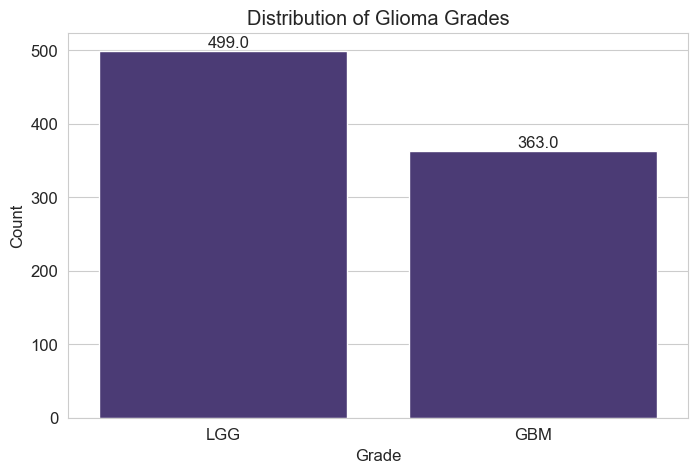

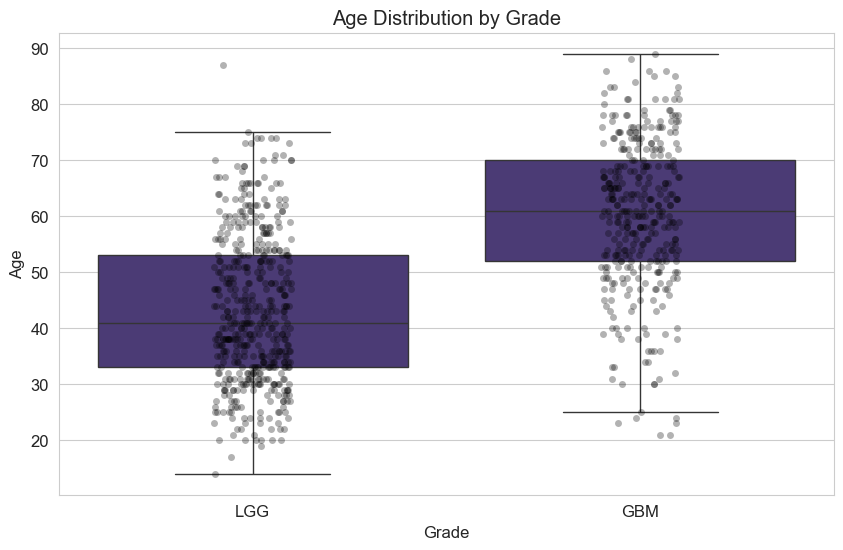

C:\Users\Tejas\AppData\Local\Temp\ipykernel_3704\1841219308.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.index, y=top15.values, palette='viridis')


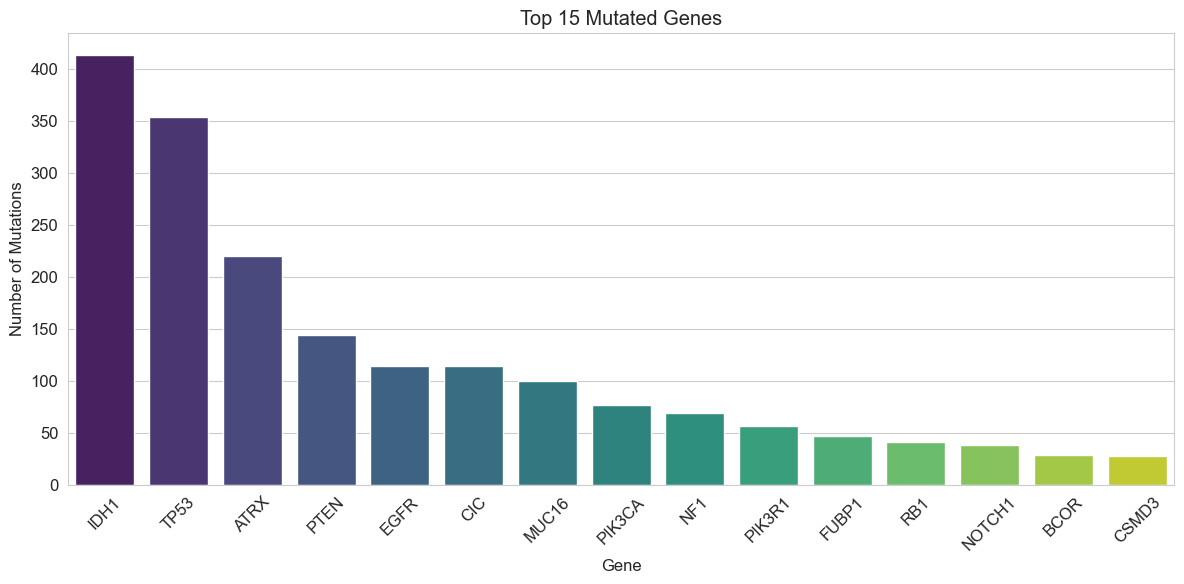

In [40]:
# Cell 4: Exploratory Data Analysis (EDA) - corrected

# Identify mutation columns more robustly: these should be all columns originally representing gene mutations,
# excluding known other columns like 'Grade', 'Gender', 'Age', 'target' or categorical columns encoded later.

# Since you dropped some columns, let's identify mutation columns as those with type int64 or float64 and not features like Age.
exclude_cols = ['Grade', 'target', 'Age', 'Gender'] + [col for col in df.columns if col.startswith('Primary_Diagnosis')] + \
               [col for col in df.columns if col.startswith('Race')]

mutation_cols = [col for col in df.columns if col not in exclude_cols]

# 1. Grade distribution plot (since you dropped 'Grade', let's recreate from 'target')
plt.figure(figsize=(8,5))
ax = sns.countplot(x=df['target'].map({0: 'LGG', 1: 'GBM'}))
plt.title("Distribution of Glioma Grades")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.35, p.get_height()+5))
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

# 2. Age distribution by grade
plt.figure(figsize=(10,6))
sns.boxplot(x=df['target'].map({0:'LGG', 1:'GBM'}), y=df['Age'], showfliers=False)
sns.stripplot(x=df['target'].map({0:'LGG', 1:'GBM'}), y=df['Age'], color='black', alpha=0.3)
plt.title("Age Distribution by Grade")
plt.xlabel("Grade")
plt.ylabel("Age")
plt.show()

# 3. Top mutated genes
# Ensure mutation columns have numeric data (they should be 0/1)
# If any mutation column has non-numeric or NaN, fill or convert them
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV (replace 'cleaned_data.csv' with your actual path if needed)
df = pd.read_csv(r'C:\Users\Tejas\OneDrive\Desktop\glioma_grading\data\glicomaxl\cleaned_data.csv')

# List of gene mutation columns (extracting from your data structure)
# Assumes all columns starting from 'IDH1' up to 'PDGFRA' are mutation binary columns
# If not, specify the gene list manually
genes = ['IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 
         'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1',
         'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']

# Filter only mutation columns that exist in dataframe
mutation_cols = [g for g in genes if g in df.columns]

# Calculate mutation counts per gene
mutation_counts = df[mutation_cols].sum().sort_values(ascending=False)

# Select top 15 mutated genes
top15 = mutation_counts.head(15)

# Plotting
plt.figure(figsize=(12,6))
sns.barplot(x=top15.index, y=top15.values, palette='viridis')

plt.title('Top 15 Mutated Genes')
plt.ylabel('Number of Mutations')
plt.xlabel('Gene')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [27]:
# %% [code]
# Cell 5: Feature Engineering
# Create binary target (1 for GBM, 0 for LGG)
df['target'] = (df['Grade'] == 'GBM').astype(int)

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Primary_Diagnosis',], drop_first=True)

# Drop original Grade column
df = df.drop('Grade', axis=1)

# Check class balance
print("Class balance:\n", df['target'].value_counts(normalize=True))



Class balance:
 target
0    0.578886
1    0.421114
Name: proportion, dtype: float64


In [28]:
# %% [code]
# Cell 6: Train-Test Split
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Training set: (689, 33)
Test set: (173, 33)


In [31]:
# %% [code]
# Cell 7: Model Training (Random Forest)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

# Save model
joblib.dump(rf, r'C:\Users\Tejas\OneDrive\Desktop\glioma_grading\data\glicomaxl\rf_model.pkl')
print("Model saved successfully")



Model saved successfully


In [32]:
# Cell 8: Model Evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

# Feature Importance
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        73

    accuracy                           1.00       173
   macro avg       1.00      1.00      1.00       173
weighted avg       1.00      1.00      1.00       173


Confusion Matrix:
[[100   0]
 [  0  73]]

ROC AUC Score: 1.0


In [33]:
sample = X_test.iloc[0:1]  # Take first test sample
print("Sample features:")
display(sample)

prediction = rf.predict(sample)[0]
probability = rf.predict_proba(sample)[0][1]

print(f"\nPrediction: {'GBM' if prediction == 1 else 'LGG'}")
print(f"Probability of GBM: {probability:.2%}")

Sample features:


,Gender,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,PIK3R1,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Age,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_not reported,Race_white,"Primary_Diagnosis_Astrocytoma, NOS","Primary_Diagnosis_Astrocytoma, anaplastic",Primary_Diagnosis_Glioblastoma,Primary_Diagnosis_Mixed glioma,"Primary_Diagnosis_Oligodendroglioma, NOS","Primary_Diagnosis_Oligodendroglioma, anaplastic"
166,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False



Prediction: LGG
Probability of GBM: 0.98%
